# INST728E - Module 7. Geospatial Analysis

We've discussed temporal and textual relevance already, and now we'll move on to spatial relevance. 

We can use this data to answer:

- What content is being posted from around the disaster's location? 
- How does this content differ from global tweets?

In [4]:
%matplotlib inline

import datetime
import json
import os

import numpy as np

# For plotting
import matplotlib
import matplotlib.pyplot as plt

# For mapping
from mpl_toolkits.basemap import Basemap

from nltk.tokenize import TweetTokenizer
#-77.119759,38.791645,-76.909393,38.995548

## Carry Forward our Event Description

We'll keep this for the GPS bounding box, which we will use below.

In [5]:
crisisInfo = {
    "Women's March": {
        "name": "Women's March 2017",
        "time": 1484992800, # 21 January 2017, 6:58 UTC to 08:11 UTC
        "directory": "womensmarch",    # Where do we find the relevant files
        "keywords": [    # How can we describe this event?
            "women's march","resist", "notmypresident","inauguration","women's right","human right","planned parenthood"
        ],
        "place": [
            38.899539,# Latitude
            -77.036551 # Longitude
        ],
        "box": {    # Where did this event occur?
            "lowerLeftLon": -77.119759,
            "lowerLeftLat": 38.791645,
            "upperRightLon": -76.909393,
            "upperRightLat": 38.995548,
        }
    },
}

In [6]:
# Replace the name below with your selected crisis
selectedCrisis = "Women's March"


<hr>

## Reading Relevant Tweets

Re-read our relevant tweets...

In [7]:

in_file_path = "/Users/yutingliao/Desktop/INST728 E/relevant_tweet_output_keywords_updated.json" # Replace this as necessary

relevant_tweets = []
with open(in_file_path, "r") as in_file:
    for line in in_file:
        relevant_tweets.append(json.loads(line.encode("utf8")))
        
print("Relevant Tweets:", len(relevant_tweets))

Relevant Tweets: 4447


<hr>
## Geographic Data

Twitter allows users to share their GPS locations when tweeting, but only about 2% of tweets have this information. 
We can extract this geospatial data to look at patterns in different locations. 

- General plotting
- Filtering by a bounding box
- Images from target location

### Plotting GPS Data

Each tweet has a field called "coordinates" describing from where the tweet was posted. 
The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). 
We want tweets with this GPS data.

For more information on tweet JSON formats, check out https://dev.twitter.com/overview/api/tweets

In [8]:
# Save only those tweets with tweet['coordinates']['coordinates'] entity
def coordinate_filter(tweet):
    return "coordinates" in tweet and tweet["coordinates"] != None

geo_tweets = list(filter(coordinate_filter, relevant_tweets))
geo_tweet_count = len(geo_tweets)

print ("Number of Geo Tweets:", geo_tweet_count)

Number of Geo Tweets: 7


In [9]:
# Save only those tweets with tweet['place'] entity
def place_filter(tweet):
    return "place" in tweet and tweet["place"] != None and tweet["coordinates"] == None

placed_tweets = list(filter(place_filter, relevant_tweets))
placed_tweet_count = len(placed_tweets)

print ("Number of Place Tweets:", placed_tweet_count)

Number of Place Tweets: 34


In [10]:
# GPS-coded tweets vs. Place-coded tweets
print("GPS-coded Tweet:")
print(json.dumps(geo_tweets[0]["coordinates"], indent=2))
print(json.dumps(geo_tweets[0]["place"], indent=2))
print()

print("Place-coded Tweet:")
print(json.dumps(placed_tweets[0]["place"], indent=2))

GPS-coded Tweet:
{
  "type": "Point",
  "coordinates": [
    4.8835516,
    52.35867134
  ]
}
{
  "id": "99cdab25eddd6bce",
  "url": "https://api.twitter.com/1.1/geo/id/99cdab25eddd6bce.json",
  "place_type": "city",
  "name": "Amsterdam",
  "full_name": "Amsterdam, The Netherlands",
  "country_code": "NL",
  "country": "The Netherlands",
  "bounding_box": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          4.7289,
          52.278227
        ],
        [
          4.7289,
          52.431229
        ],
        [
          5.079207,
          52.431229
        ],
        [
          5.079207,
          52.278227
        ]
      ]
    ]
  },
  "attributes": {}
}

Place-coded Tweet:
{
  "id": "015b41f2459305d0",
  "url": "https://api.twitter.com/1.1/geo/id/015b41f2459305d0.json",
  "place_type": "city",
  "name": "Blasdell",
  "full_name": "Blasdell, NY",
  "country_code": "US",
  "country": "United States",
  "bounding_box": {
    "type": "Polygon",
    "coordinate

### Plotting GPS Data

Now that we have a list of all the tweets with GPS coordinates, we can plot from where in the world these tweets were posted. 
To make this plot, we can leverage the Basemap package to make a map of the world and convert GPS coordinates to *(x, y)* coordinates we can then plot.

/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


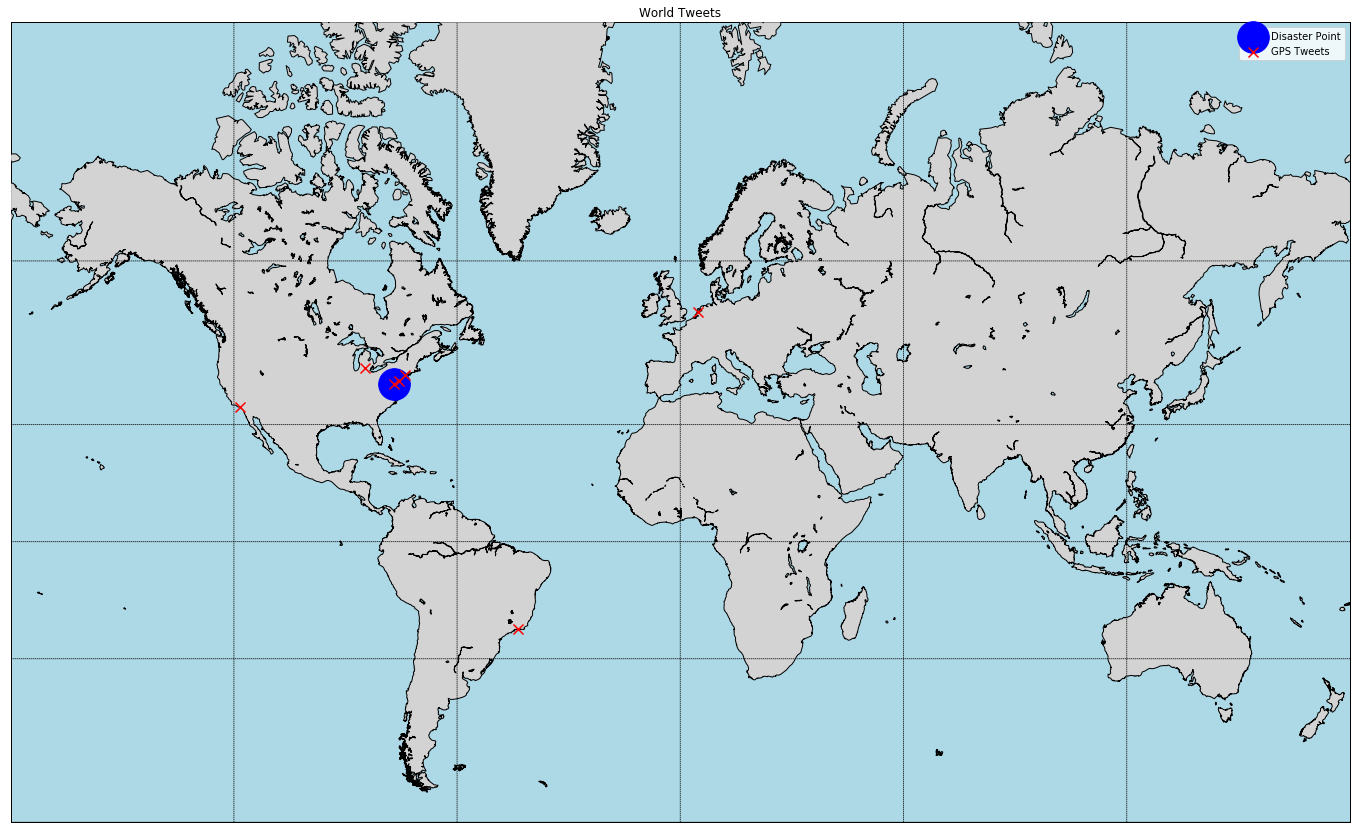

In [11]:
# For each geo-coded tweet, extract its GPS coordinates
geoCoord = [x["coordinates"]["coordinates"] for x in geo_tweets]

# Now we build a map of the world using Basemap
land_color = 'lightgray'
water_color = 'lightblue'

# Create a nice, big figure
fig, ax = plt.subplots(figsize=(24,24))

# Build our map, focusing on most of the world and using
#  a Mercator project (many map projections exist)
worldMap = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80,
                   llcrnrlon=-180, urcrnrlon=180, resolution='l')

# Make the map readable
worldMap.fillcontinents(color=land_color, lake_color=water_color, zorder=1)
worldMap.drawcoastlines()
worldMap.drawparallels(np.arange(-90.,120.,30.))
worldMap.drawmeridians(np.arange(0.,420.,60.))
worldMap.drawmapboundary(fill_color=water_color, zorder=0)
ax.set_title('World Tweets')

place_point = worldMap(
    crisisInfo[selectedCrisis]["place"][1], # Longitude
    crisisInfo[selectedCrisis]["place"][0], # Latitude
)
worldMap.scatter(place_point[0], place_point[1], 
                 s=1000, marker="o", color="blue", zorder=2,
                label="Disaster Point")

# Convert points from GPS coordinates to (x,y) coordinates
convPoints = [worldMap(p[0], p[1]) for p in geoCoord]

# Split out points for X,Y lists, which we'll use for our
#  standard Matplotlib plotting
x = [p[0] for p in convPoints]
y = [p[1] for p in convPoints]

# Plot the points on the map
worldMap.scatter(x, y, 
                 s=100, marker='x', color="red", zorder=2,
                label="GPS Tweets")

plt.legend()
plt.show()

### Filtering By Location

We can use existing Geographic Information System (GIS) tools to determine from where a tweet was posted.
For example, we could ask whether a particular tweet was posted from the United States. 
This filtering is often performed using shape files.
For our purposes though, we established a bounding box along with the crisis data, so we'll use that as our filter for simplicity.

/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Tweets in Target Area: 1
Tweets outside: 6


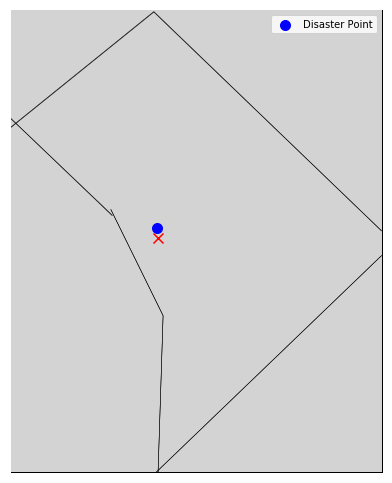

In [27]:
# Get the bounding box for our crisis
bBox = crisisInfo[selectedCrisis]["box"]

fig, ax = plt.subplots(figsize=(11,8.5))

# Create a new map to hold the shape file data
targetMap = Basemap(llcrnrlon=bBox["lowerLeftLon"], 
                    llcrnrlat=bBox["lowerLeftLat"], 
                    urcrnrlon=bBox["upperRightLon"], 
                    urcrnrlat=bBox["upperRightLat"], 
                    projection='merc',
                    resolution='i', area_thresh=10000)

targetMap.fillcontinents(color=land_color, lake_color=water_color, 
                         zorder=1)
targetMap.drawcoastlines()
targetMap.drawstates()
targetMap.drawparallels(np.arange(-90.,120.,30.))
targetMap.drawmeridians(np.arange(0.,420.,60.))
targetMap.drawmapboundary(fill_color=water_color, zorder=0)
targetMap.drawcountries()

place_point = targetMap(
    crisisInfo[selectedCrisis]["place"][1], # Longitude
    crisisInfo[selectedCrisis]["place"][0], # Latitude
)
targetMap.scatter(place_point[0], place_point[1], 
                 s=100, marker="o", color="blue", zorder=2,
                label="Disaster Point")

# Now we build the polygon for filtering
# Convert from lon, lat of lower-left to x,y coordinates
llcCoord = targetMap(bBox["lowerLeftLon"], bBox["lowerLeftLat"])

# Same for upper-right corner
urcCoord = targetMap(bBox["upperRightLon"], bBox["upperRightLat"])

# Now make the polygon we'll us for filtering
boxPoints = np.array([[llcCoord[0], llcCoord[1]], 
                      [llcCoord[0], urcCoord[1]], 
                      [urcCoord[0], urcCoord[1]], 
                      [urcCoord[0], llcCoord[1]]])
boundingBox = matplotlib.patches.Polygon(boxPoints)

# For each geo-coded tweet, extract coordinates and convert 
# them to the Basemap space
convPoints = [targetMap(p[0], p[1]) for p in geoCoord]

# Track points within our bounding box
plottable = []

# For each point, check if it is within the bounding box or not
for point in convPoints:
    x = point[0]
    y = point[1]

    if ( boundingBox.contains_point((x, y))):
        plottable.append(point)

# Plot points in our target
targetMap.scatter([p[0] for p in plottable], [p[1] for p in plottable], s=100, 
                  marker='x', color="red", zorder=2)
            
print ("Tweets in Target Area:", len(plottable))
print ("Tweets outside:", (geo_tweet_count - len(plottable)))

plt.legend()
plt.show()

### Few GPS-coded Points Exist

So it's useful to use the `place`-coded tweets as well. Let's see where they are.

/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


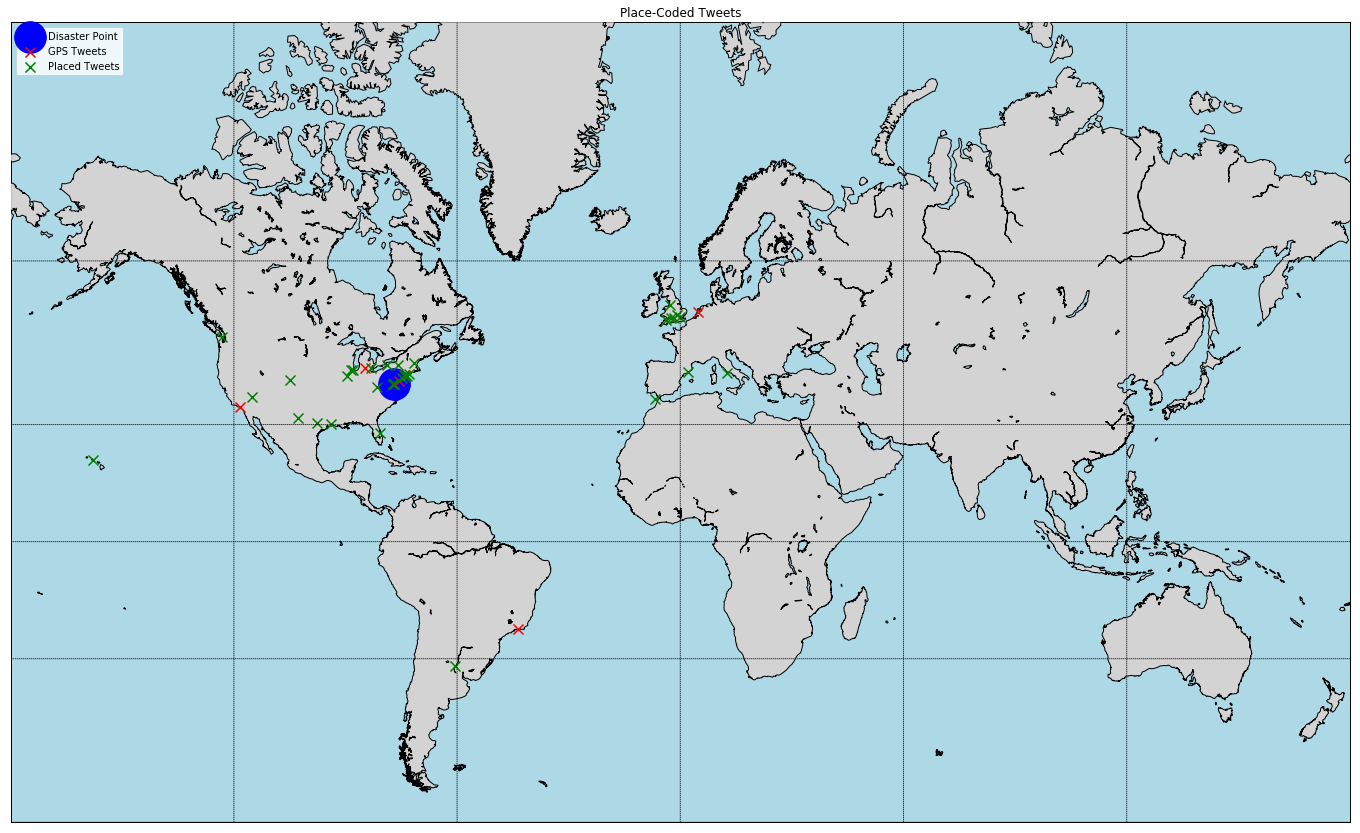

In [20]:
# This function takes a bounding box and finds its center point
#  NOTE: This is a not-so-great hack and can lead to strange behavior
#  (e.g., points in the middle of lakes or at random houses)
def flatten_bbox(tweet):
    lat = 0.0
    lon = 0.0
    
    p_count = 0
    for poly in tweet["place"]["bounding_box"]["coordinates"]:
        for p in poly:
            lat += p[1]
            lon += p[0]
            p_count += 1
        
    # Take the average location
    if ( p_count > 0 ):
        lat = lat / p_count
        lon = lon / p_count
        
    return (lon, lat)

# Extract flattened GPS coordinates
place_geocodes = [flatten_bbox(x) for x in placed_tweets]

# Now we build a map of the world using Basemap
land_color = 'lightgray'
water_color = 'lightblue'

# Create a nice, big figure
fig, ax = plt.subplots(figsize=(24,24))

# Build our map, focusing on most of the world and using
#  a Mercator project (many map projections exist)
worldMap = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80,
                   llcrnrlon=-180, urcrnrlon=180, resolution='l')

# Make the map readable
worldMap.fillcontinents(color=land_color, lake_color=water_color, zorder=1)
worldMap.drawcoastlines()
worldMap.drawparallels(np.arange(-90.,120.,30.))
worldMap.drawmeridians(np.arange(0.,420.,60.))
worldMap.drawmapboundary(fill_color=water_color, zorder=0)
ax.set_title('Place-Coded Tweets')

place_point = worldMap(
    crisisInfo[selectedCrisis]["place"][1], # Longitude
    crisisInfo[selectedCrisis]["place"][0], # Latitude
)

worldMap.scatter(place_point[0], place_point[1], 
                 s=1000, marker="o", color="blue", zorder=2,
                label="Disaster Point")

# Convert points from GPS coordinates to (x,y) coordinates
convPoints = [worldMap(p[0], p[1]) for p in geoCoord]

# Split out points for X,Y lists, which we'll use for our
#  standard Matplotlib plotting
x = [p[0] for p in convPoints]
y = [p[1] for p in convPoints]

# Plot the points on the map
worldMap.scatter(x, y, 
                 s=100, marker='x', color="red", zorder=2,
                label="GPS Tweets")

# Place points in a different color
conv_place_points = [worldMap(p[0], p[1]) for p in place_geocodes]
# Plot the points on the map
worldMap.scatter([p[0] for p in conv_place_points], [p[1] for p in conv_place_points], 
                 s=100, marker='x', color="green", zorder=2,
                label="Placed Tweets")

plt.legend()
plt.show()

### Placed Tweets in Disaster Zone

GPS Tweets in Target Area: 1
GPS Tweets outside: 6
Placed Tweets in Target Area: 2
Placed Tweets outside: 32


/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yutingliao/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


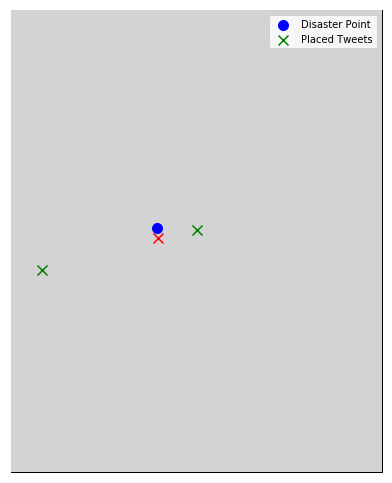

In [21]:
fig, ax = plt.subplots(figsize=(11,8.5))

# Create a new map to hold the shape file data
targetMap = Basemap(llcrnrlon=bBox["lowerLeftLon"], 
                    llcrnrlat=bBox["lowerLeftLat"], 
                    urcrnrlon=bBox["upperRightLon"], 
                    urcrnrlat=bBox["upperRightLat"], 
                    projection='merc',
                    resolution='i', area_thresh=10000)

targetMap.fillcontinents(color=land_color, lake_color=water_color, 
                         zorder=1)
targetMap.drawcoastlines()
targetMap.drawparallels(np.arange(-90.,120.,30.))
targetMap.drawmeridians(np.arange(0.,420.,60.))
targetMap.drawmapboundary(fill_color=water_color, zorder=0)
targetMap.drawcountries()

place_point = targetMap(
    crisisInfo[selectedCrisis]["place"][1], # Longitude
    crisisInfo[selectedCrisis]["place"][0], # Latitude
)
targetMap.scatter(place_point[0], place_point[1], 
                 s=100, marker="o", color="blue", zorder=2,
                label="Disaster Point")

# Now we build the polygon for filtering
# Convert from lon, lat of lower-left to x,y coordinates
llcCoord = targetMap(bBox["lowerLeftLon"], bBox["lowerLeftLat"])

# Same for upper-right corner
urcCoord = targetMap(bBox["upperRightLon"], bBox["upperRightLat"])

# Now make the polygon we'll us for filtering
boxPoints = np.array([[llcCoord[0], llcCoord[1]], 
                      [llcCoord[0], urcCoord[1]], 
                      [urcCoord[0], urcCoord[1]], 
                      [urcCoord[0], llcCoord[1]]])
boundingBox = matplotlib.patches.Polygon(boxPoints)

# For each geo-coded tweet, extract coordinates and convert 
# them to the Basemap space
convPoints = [targetMap(p[0], p[1]) for p in geoCoord]

# Track points within our bounding box
plottable = []

# For each point, check if it is within the bounding box or not
for point in convPoints:
    x = point[0]
    y = point[1]

    if ( boundingBox.contains_point((x, y))):
        plottable.append(point)

# Plot points in our target
targetMap.scatter([p[0] for p in plottable], [p[1] for p in plottable], s=100, 
                  marker='x', color="red", zorder=2)

print ("GPS Tweets in Target Area:", len(plottable))
print ("GPS Tweets outside:", (geo_tweet_count - len(plottable)))

# Place points in a different color
plottable_p2 = []
conv_place_points = [targetMap(p[0], p[1]) for p in place_geocodes]
for point in conv_place_points:
    x = point[0]
    y = point[1]

    if ( boundingBox.contains_point((x, y))):
        plottable_p2.append(point)
        
# Plot the points on the map
targetMap.scatter([p[0] for p in plottable_p2], [p[1] for p in plottable_p2], 
                 s=100, marker='x', color="green", zorder=2,
                label="Placed Tweets")
        
print ("Placed Tweets in Target Area:", len(plottable_p2))
print ("Placed Tweets outside:", (placed_tweet_count - len(plottable_p2)))

plt.legend()
plt.show()

### Build a list of spatially relevant tweets

Above, we just plotted tweet locations. Now let's save tweets that are geographically relevant.

In [22]:
# Now we build the polygon for filtering
llcCoord = (bBox["lowerLeftLon"], bBox["lowerLeftLat"])

# Same for upper-right corner
urcCoord = (bBox["upperRightLon"], bBox["upperRightLat"])

# Now make the polygon we'll us for filtering
boxPoints = np.array([[llcCoord[0], llcCoord[1]], 
                      [llcCoord[0], urcCoord[1]], 
                      [urcCoord[0], urcCoord[1]], 
                      [urcCoord[0], llcCoord[1]]])
boundingBox = matplotlib.patches.Polygon(boxPoints)

# Our list of spatially relevant tweets
spatial_relevant_tweets_gps = []
spatial_relevant_tweets_placed = []

# First check GPS tweets
for tweet in geo_tweets:
    x, y = tweet["coordinates"]["coordinates"]
    if ( boundingBox.contains_point((x, y))):
        spatial_relevant_tweets_gps.append(tweet)
        
print("Spatially Relevant GPS-coded Tweets:", len(spatial_relevant_tweets_gps))

# Then check Place tweets
for tweet in placed_tweets:
    x, y = flatten_bbox(tweet)
    if ( boundingBox.contains_point((x, y))):
        spatial_relevant_tweets_placed.append(tweet)
        
print("Spatially Relevant Tweets:", len(spatial_relevant_tweets_placed))

# Merge relevant tweets
spatial_relevant_tweets = spatial_relevant_tweets_gps + spatial_relevant_tweets_placed

Spatially Relevant GPS-coded Tweets: 1
Spatially Relevant Tweets: 2


### Geographically Relevant Tweet Content

Now that we have a list of tweets from the target area, what are they saying?

In [23]:
# Print the relevant tweets
for tweet in spatial_relevant_tweets[:10]:
    print("Tweet By:", tweet["user"]["screen_name"])
    print("\t", "Tweet Text:", tweet["text"])
    print("\t", "Tweet Time:", tweet["created_at"])
    print("\t", "Source:", tweet["source"])
    print("\t", "Twitter's Guessed Language:", tweet["lang"])
    if ( "place" in tweet ):
        print("\t", "Tweet Location:", tweet["place"]["full_name"])
    print("-----")

Tweet By: Sassynovaknows
	 Tweet Text: At the Women's March with my girl Latoya!! My girl held it down on the drums while marching… https://t.co/4lxDg9GYAB
	 Tweet Time: Mon Jan 23 22:02:12 +0000 2017
	 Source: <a href="http://instagram.com" rel="nofollow">Instagram</a>
	 Twitter's Guessed Language: en
	 Tweet Location: Washington, DC
-----
Tweet By: brooke_fenex
	 Tweet Text: The vast amount of women here for the Women's March on Washington swells my heart w/ hope.
	 Tweet Time: Sat Jan 21 15:08:36 +0000 2017
	 Source: <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
	 Twitter's Guessed Language: en
	 Tweet Location: Arlington, VA
-----
Tweet By: HaleyGPilgrim
	 Tweet Text: Angela Davis #WomensMarch #resist https://t.co/CJ0Zdyr4mV
	 Tweet Time: Sat Jan 21 20:50:04 +0000 2017
	 Source: <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
	 Twitter's Guessed Language: in
	 Tweet Location: Washington, DC
-----


### Media from Within Target

With this filtered list of tweets, we can extract media posted from the evnet.

In [24]:
from IPython.display import display
from IPython.display import Image

geoTweetsWithMedia = list(filter(lambda tweet: "media" in tweet["entities"], 
                                 spatial_relevant_tweets))
print ("Tweets with Media:", len(geoTweetsWithMedia))

if ( len(geoTweetsWithMedia) == 0 ):
    print ("Sorry, not tweets with media...")

for tweet in geoTweetsWithMedia:
    print(tweet["text"])
    for media in tweet["entities"]["media"]:
        print("\tType:", media["type"])
        print("\t%s" % media["expanded_url"])
        display(Image(url=media["media_url"]))

Tweets with Media: 1
Angela Davis #WomensMarch #resist https://t.co/CJ0Zdyr4mV
	Type: photo
	https://twitter.com/HaleyGPilgrim/status/822909148878749696/video/1


## Geospatial + Temporal Relevance

We can also convert these geocoded tweets to time series and plot them as we with the time-series relevance module.

In [25]:
# Twitter's time format, for parsing the created_at date
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

# Frequency map for tweet-times
rel_frequency_map = {}
for tweet in relevant_tweets:
    # Parse time
    currentTime = datetime.datetime.strptime(tweet['created_at'], timeFormat)

    # Flatten this tweet's time
    currentTime = currentTime.replace(second=0,minute = 0)

    # If our frequency map already has this time, use it, otherwise add
    extended_list = rel_frequency_map.get(currentTime, [])
    extended_list.append(tweet)
    rel_frequency_map[currentTime] = extended_list

# Frequency map for tweet-times
geo_frequency_map = {}
for tweet in spatial_relevant_tweets:
    # Parse time
    currentTime = datetime.datetime.strptime(tweet['created_at'], timeFormat)

    # Flatten this tweet's time
    currentTime = currentTime.replace(second=0,minute = 0)

    # If our frequency map already has this time, use it, otherwise add
    extended_list = geo_frequency_map.get(currentTime, [])
    extended_list.append(tweet)
    geo_frequency_map[currentTime] = extended_list
    
    
# Fill in any gaps
times = sorted(set(rel_frequency_map.keys()).union(set(geo_frequency_map)))
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

# We want to look at per-minute data, so we fill in any missing minutes
timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
while ( thisTime <= lastTime ):

    rel_frequency_map[thisTime] = rel_frequency_map.get(thisTime, [])
    geo_frequency_map[thisTime] = geo_frequency_map.get(thisTime, [])
        
    thisTime = thisTime + timeIntervalStep

# Count the number of minutes
print ("Start Time:", firstTime)
print ("Stop Time:", lastTime)
print ("Processed Times:", len(rel_frequency_map))

Start Time: 2017-01-21 10:00:00
Stop Time: 2017-01-24 23:00:00
Processed Times: 5101


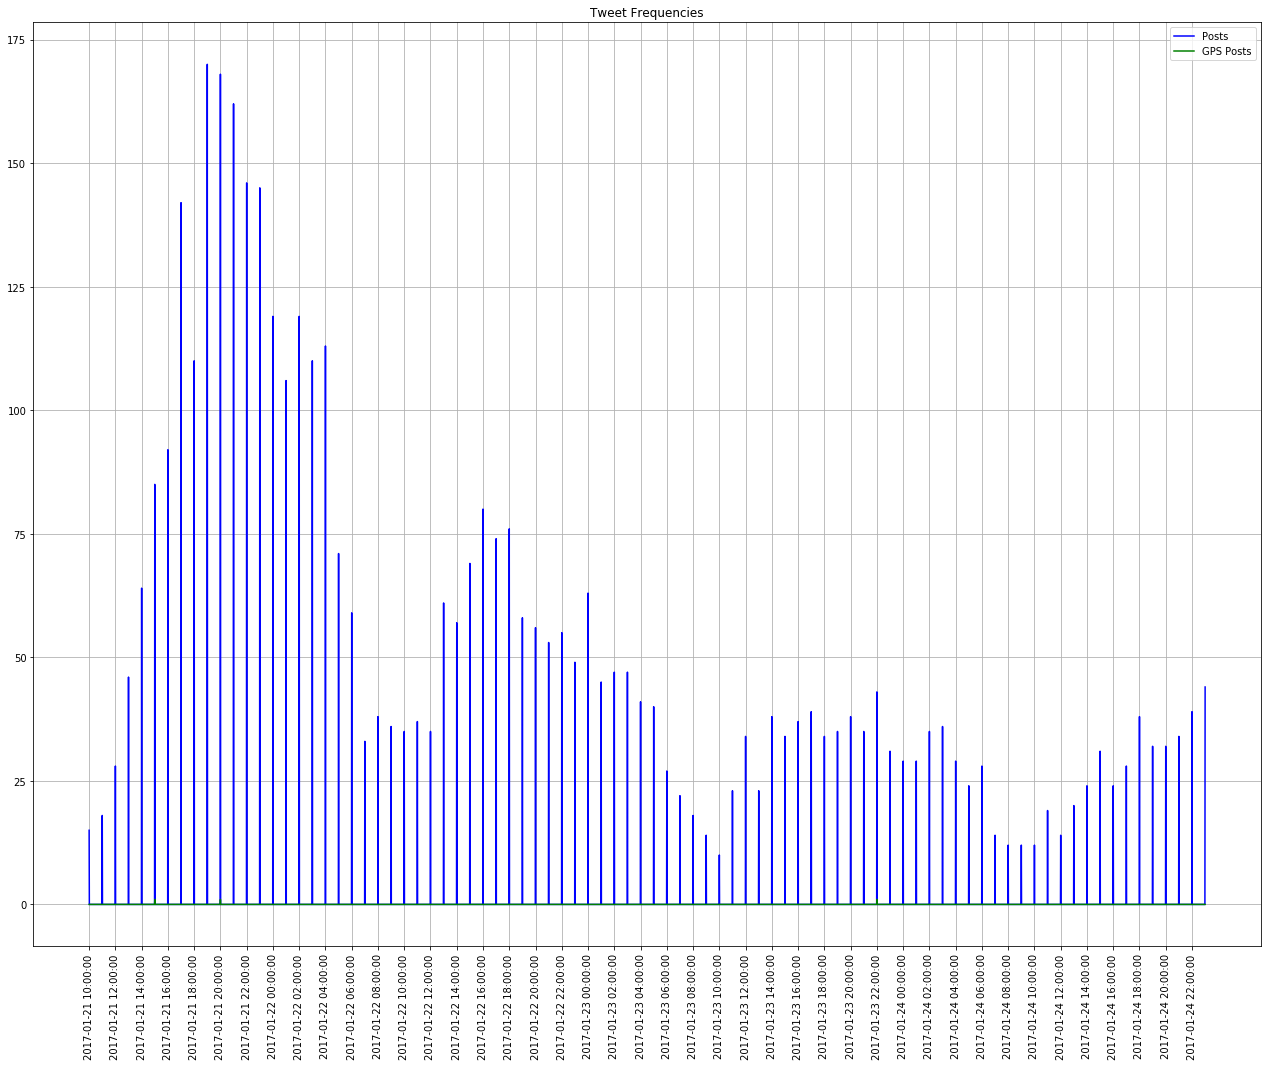

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(22, 17)

plt.title("Tweet Frequencies")

sortedTimes = sorted(rel_frequency_map.keys())
gpsFreqList = [len(geo_frequency_map[x]) for x in sortedTimes]
postFreqList = [len(rel_frequency_map[x]) for x in sortedTimes]

smallerXTicks = range(0, len(sortedTimes), 120)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

ax.plot(xData, postFreqList, color="blue", label="Posts")
ax.plot(xData, gpsFreqList, color="green", label="GPS Posts")

ax.grid(b=True, which=u'major')
ax.legend()

plt.show()